# Предобработка данных

## Настройка среды

In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

NOTEBOOK_ID = '1'  # в выходных данных будет указан этот id
RANDOM_SEED = 0  # для воспроизводимости результатов
ROOT_PATH = Path('..')  # путь к корню проекта

In [2]:
import datetime as dt

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from feature_engine.imputation import DropMissingData

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

import uai.data

## Загрузка данных
Разбираемся во всем наборе данных (формат, описания сердечно-сосудистых событий, ошибки заполнения, ...). Анализ для создания новых признаков будем проводить позже и только на данных для обучения.

In [3]:
df = uai.data.load_dataset(ROOT_PATH)
print(f'Загружено случаев: {df.shape[0]}')
df.head(3)

Загружено случаев: 1468


,institution,id,gender,age,dose,date_analyse,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,institution_id,diagnos,sss,birthdate
0,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.5,2022-11-11,3.11,1,0,0,13.0,3.32,1,0,20,Фибрилляция предсердий,NaN,1965-11-11
1,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.5,2022-11-24,3.32,1,0,0,15.0,2.01,2,0,20,Фибрилляция предсердий,NaN,1965-11-11
2,ГБУЗ РБ Толбазинская ЦРБ,140361892057264,1,50,5.0,2022-11-22,2.01,0,1,0,26.0,2.75,1,0,20,ПротезированиеМитрального клапана,NaN,1972-11-22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   institution          1468 non-null   object        
 1   id                   1468 non-null   int64         
 2   gender               1468 non-null   int64         
 3   age                  1468 non-null   int64         
 4   dose                 1468 non-null   float64       
 5   date_analyse         1468 non-null   datetime64[ns]
 6   prev_INR(MHO)        1468 non-null   float64       
 7   atrial_fibrillation  1468 non-null   int64         
 8   mitral_valve         1468 non-null   int64         
 9   aortal_valve         1468 non-null   int64         
 10  date_diff            1467 non-null   float64       
 11  INR(MHO)             1468 non-null   float64       
 12  sample               1468 non-null   int64         
 13  pass_dose            1468 non-nul

In [5]:
# Типы данных не всегда определяются корректно, поэтому приведем их к нужному типу

def set_dtypes(df):
    res_df = df.copy()
    
    res_df['date_analyse'] = res_df['date_analyse'].astype('datetime64[ns]')
    res_df['birthdate'] = res_df['birthdate'].astype('datetime64[ns]')
    
    return res_df

In [6]:
# Делим данные на тестовую и обучающую выборки и сохраняем в файлы

train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

print(f'Размер обучающей выборки: {train_df.shape[0]}')
print(f'Размер тестовой выборки:  {test_df.shape[0]}')

train_df.to_csv(ROOT_PATH / f'data/interim/train_{NOTEBOOK_ID}.csv', index=False)
test_df.to_csv(ROOT_PATH / f'data/interim/test_{NOTEBOOK_ID}.csv', index=False)

Размер обучающей выборки: 1174
Размер тестовой выборки:  294


## Парсинг данных - выделение по группам (оставлен код исходного парсера)
* возрастов
* диагнозов
* вычисление относительной даты анализа

In [7]:
# В файл ЦАТ_общий_parsed_extDS_v6.xlsx относительно ЦАТ_общий_parsed.xlsx
# добавлены:
# institution_id - id лечебного учреждения (на основании первого столбца с названием)
# diagnos и sss - записи о диагнозе и сердечно-сосудистых событиях из первичных файлов

# Группы диагнозов: обрабатываются поля диагнозов и сердечно-сосудистых событий
# d1 - Протезирование клапанов
# d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
# d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
# d4 - (I05-09)Ревматическая болезнь сердца
# d5 - (I35)Неревматические поражения аортального клапана
# d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
# d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
# d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)

# Группы возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

# Относительная давность анализа:
# date_from_1990 = количество дней от 01.01.1990 до date_analyse

### Функции для формирования доп.колонок (код сохранен без изменений исходного парсера).
Создаются новые столбцы по группам возрастов, по группам заболеваний и столбец с относительной давностью анализа:  date_from_1990

In [8]:
# Сформируем колонки по группам возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

def get_level(x):
# age_level	0-10-30-50-60-70-80-90+
    if x < 10 : return 0
    if x >= 10 and x < 30 : return 10
    if x >= 30 and x < 50 : return 30
    if x >= 50 and x < 60 : return 50
    if x >= 60 and x < 70 : return 60
    if x >= 70 and x < 80 : return 70
    if x >= 80 and x < 90 : return 80
    return 90

def get_level1(x):
# age_level1	0-50-65-75-80+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 80 : return 75
    return 80

def get_level2(x):
# age_level2	0-35-50-65-80+
    if x < 35 : return 0
    if x >= 35 and x < 50 : return 35
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level3(x):
# age_level3	0-50-65-75-90+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 90 : return 75
    return 90

def get_level4(x):
# age_level4	0-50-65-80
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level5(x):
# age_level5	0-50-65+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    return 65

In [9]:
# поисковые конструкции для diagnos и sss
# for d1 -диагноз или ссс содержат слово "проте"
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
# for d5-  I35,i35
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
# for d7 - аорт, митр,клап,перегор
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац

def get_d1(x):
  # for d1 -диагноз или ссс содержат слово "проте"
  wlist = ['проте']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d2(x):
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
  wlist = ['фибр', 'фебр','ФП','трепет','i48','I48','I 48']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d3(x):
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
  wlist = ['порок','ИБС','склероз','ОИМ','инфаркт','миокард','стенокар','I20',
           'I25','ПИКС','пикс','ишемич','кард','ВПС','ОКС','стенокард',
           'ТИА','эндокардит','порок']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d4(x):
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
  wlist = ['I 08','I05','i05','i08','I06','I09','ревмат']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d5(x):
# for d5-  I35,i35
  wlist = ['I35','i35']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d6(x):
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
  wlist = ['ДКМП', 'I42', 'ОНМК','i34','Q231','ГБ','легочн','ТЭЛА']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d7(x):
# for d7 - аорт, митр,клап,перегор
  wlist = ['аорт', 'митр','клап','перегор']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d8(x):
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац
  wlist = ['АКШ','МКШ','шунт','стент','ЭКС','РЧА','аблац']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

In [10]:
def add_date_from_1990(df):
    # Вычисли относительную давность анализа:
    # сформируем колонку date_from_1990 = количество дней от 01.01.1990 до date_analyse
    date_19900101 = dt.datetime(1990, 1, 1)

    df['date_from_1990'] = (df['date_analyse'] - date_19900101).dt.days
    return df

In [11]:
def add_age_levels(df):
    """
    Сформируем колонки по группам возрастов: на основе поля возраст
        age_level	0-10-30-50-60-70-80-90+
        age_level1	0-50-65-75-80+
        age_level2	0-35-50-65-80+
        age_level3	0-50-65-75-90+
        age_level4	0-50-65-80
        age_level5	0-50-65+
        age_level6	0-65+
    """
    df['age_level'] = df['age'].apply(get_level)
    df['age_level1'] = df['age'].apply(get_level1)
    df['age_level2'] = df['age'].apply(get_level2)
    df['age_level3'] = df['age'].apply(get_level3)
    df['age_level4'] = df['age'].apply(get_level4)
    df['age_level5'] = df['age'].apply(get_level5)
    df['age_level6'] = np.where((df.age>=65), 65, 0)

    return df

## Сформируем колонки по диагнозам и ССС

In [12]:
def add_diagnosis_and_sss(df):
    """
    Сформируем колонки по диагнозам и ССС: на основе колонок diagnos, sss
        d1 - Протезирование клапанов
        d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
        d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
        d4 - (I05-09)Ревматическая болезнь сердца
        d5 - (I35)Неревматические поражения аортального клапана
        d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
        d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
        d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)
    """
    # приводим к типу 'str'
    df['diagnos'] = df['diagnos'].astype(str)
    df['sss'] = df['sss'].astype(str)

    df['d1'] = df.apply(lambda x: get_d1(x), axis=1)
    df['d2'] = df.apply(lambda x: get_d2(x), axis=1)
    df['d3'] = df.apply(lambda x: get_d3(x), axis=1)
    df['d4'] = df.apply(lambda x: get_d4(x), axis=1)
    df['d5'] = df.apply(lambda x: get_d5(x), axis=1)
    df['d6'] = df.apply(lambda x: get_d6(x), axis=1)
    df['d7'] = df.apply(lambda x: get_d7(x), axis=1)
    df['d8'] = df.apply(lambda x: get_d8(x), axis=1)

    return df

## Анализ распределения возраста пациентов
На основании этого анализа хотим понять, как распределен возраст. И определить диапазон, вне которого будем считать возраст ошибочным.

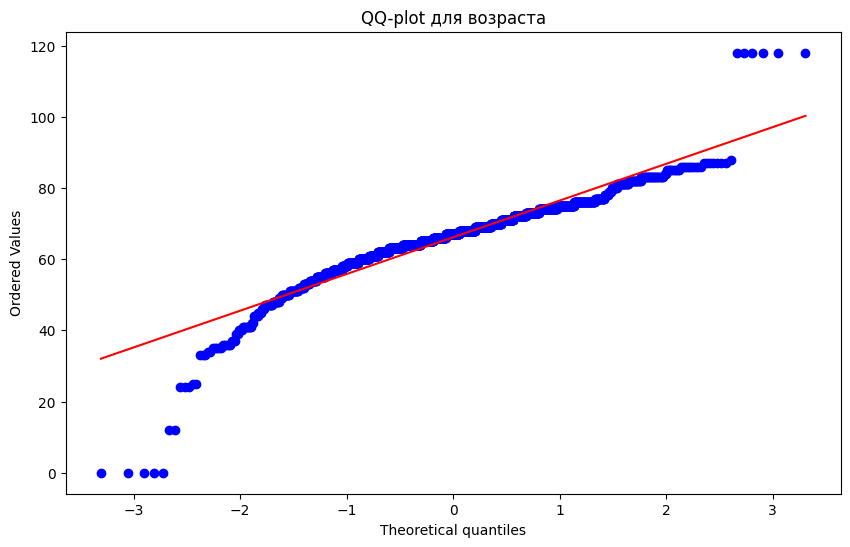

In [13]:
# QQ-plot - это графический инструмент, который помогает определить,
# насколько близки данные к некоторому теоретическому распределению,
# чаще всего к нормальному. Если распределение идеально совпадает с нормальным,
# то точки на QQ-plot будут следовать прямой линии (45-градусной)

import scipy.stats as stats

def plot_age_qq(series):
    plt.figure(figsize=(10, 6))
    stats.probplot(series, plot=plt)
    plt.title('QQ-plot для возраста')

plot_age_qq(df['age'])

Количество записей с ошибками: 11


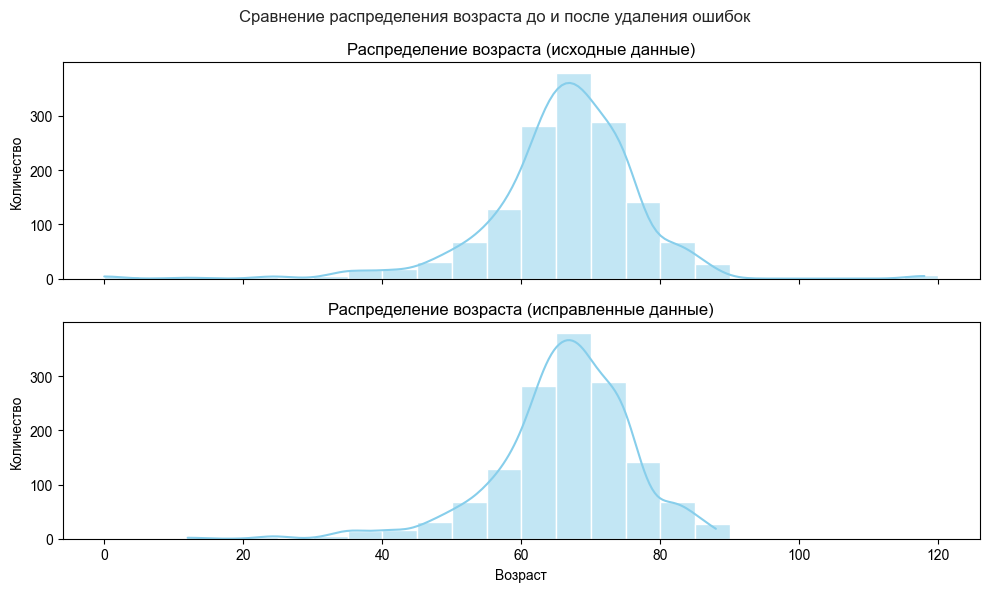

In [14]:
# Удаляем явные ошибки из датасета

def remove_age_errors(df):
    """
    Удаляем явные ошибки из датасета: возраст 0 и больше 100.
    """
    df = df.drop(df[(df['age'] <= 0) | (df['age'] > 100)].index)
    return df

def plot_age_hist(ages, ax):
    """
    Гистограмма распределения возраста.
    """
    sns.set_style("whitegrid")

    sns.histplot(ages, bins=range(0, 121, 5), kde=True, color="skyblue", ax=ax)
    ax.set_xlabel('Возраст')
    ax.set_ylabel('Количество')


age_fixed_df = remove_age_errors(df.copy())
# plot_age_hist(data_age_fixed['age'])

# Создаем фигуру и две оси
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Построим гистограмму для исходных данных на первой оси
plot_age_hist(df['age'].copy(), ax1)
ax1.set_title('Распределение возраста (исходные данные)')

# Построим гистограмму для исправленных данных на второй оси
data_age_fixed = remove_age_errors(df.copy())
plot_age_hist(age_fixed_df['age'], ax2)
ax2.set_title('Распределение возраста (исправленные данные)')

fig.suptitle('Сравнение распределения возраста до и после удаления ошибок')
plt.tight_layout()

print(f'Количество записей с ошибками: {df.shape[0] - age_fixed_df.shape[0]}')

In [15]:
# Тест Андерсона-Дарлинга

result = stats.anderson(data_age_fixed['age'])

print(f"Anderson-Darling Test: Statistic={result.statistic}")
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

Anderson-Darling Test: Statistic=15.66016396291252
Critical values: [0.574 0.654 0.785 0.915 1.089]
Significance levels: [15.  10.   5.   2.5  1. ]


Результат тестов показывает, что что **распределение данных в столбце 'age' не следует нормальному распределению**. Прямое применение стандартных методов машинного обучения может не давать оптимальных результатов, так как большинство методов предполагает, что признаки имеют некое стандартное или нормальное распределение. Но есть модели, устойчивые к несбалансированным данным: модели на основе деревьев хорошо работают с такими данными.

## Расчет статистических метрик по столбцу age

Для дальнейшей оценки кореляции и принятия решения о включении в датасет на базе занных о возрасте рассчитываются следующие статистические показатели  (можно использовать другие):

**deviation_from_median**: Отклонение возраста от медианного значения возраста в датасете. Если значение положительное, возраст выше медианы; если отрицательное — ниже медианы.

**age_percentile**: Процентное положение возраста относительно всех остальных возрастов в наборе данных. Он показывает, сколько процентов людей в датасете имеют возраст ниже данного значения.

**age_quantile**: Показатель делит возраста на четыре равные части (квартили). При этом значение 1 соответствует самому нижнему квартилю (25% самых молодых), а 4 — самому верхнему квартилю (25% самых старых).

**is_elderly**: Бинарный параметр показывает, превышает ли возраст заданный порог. Если да, то значение равно 1, в противном случае — 0.

**age_density**: Оценка плотности вероятности для каждого возраста в датасете показывает, насколько "обычным" или "редким" является определенный возраст среди всех возрастов в датасете.

**age_zscore**: Z-оценка для возраста показывает, на сколько стандартных отклонений конкретное значение возраста отклоняется от среднего значения возраста в ндатасете. Если Z-оценка положительна, возраст выше среднего, и наоборот.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats

class AgeStatisticsTransformer(BaseEstimator, TransformerMixin):
    """
    Трансформер, создающий новые признаки:
        - age_deviation_from_median
        - age_percentile
        - age_quantile
        - is_elderly
        - age_density
        - age_zscore
    """

    def __init__(self):
        self.ages = None
        self.mean_age = None
        self.median_age = None
        self.std_age = None

    def fit(self, X, y=None):
        """
        Запоминаем статистический данные обучающей выдорки.
        """
        self.ages = X['age'].copy()  # копируем столбец возрастов
        self.mean_age = X['age'].mean() # средний возраст
        self.median_age = X['age'].median() # медианный возраст
        self.std_age = X['age'].std()  # стандартное отклонение
        
        return self  # возвращаем себя для цепочки вызовов

    def transform(self, X, y=None):
        """
        Создаем новые признаки, сравнивая df с запомненными статистическими данными обучающей выборки.
        """
        res_df = X.copy()  # Копируем датафрейм, чтобы не менять исходный

        res_df['age_deviation_from_median'] = res_df['age'] - self.median_age
        res_df['age_percentile'] = res_df['age'].apply(lambda x: stats.percentileofscore(self.ages, x))
        
        # TODO: восстановить вычисление квантилей
        # res_df['age_quantile'] = pd.qcut(self.ages, q=4, labels=[1, 2, 3, 4])

        threshold = 70
        res_df['is_elderly'] = (res_df['age'] > threshold).astype('int8')

        res_df['age_density'] = res_df['age'].apply(lambda x: float(stats.gaussian_kde(self.ages)(x)))

        res_df['age_zscore'] = (res_df['age'] - self.mean_age) / self.std_age

        return res_df

## Cоздание дополнительные признаков

In [17]:
# Функция Отклонение (лет) от критического возраста: critical_age_l - младше порога;
# critical_age_h - старше порога

critical_age_threshold = 40  # принятый порог критического возраста

def add_critical_age(df,tr_age=critical_age_threshold):
    if 'age' in df.columns and 'int' in df.age.dtype.name:
        df['critical_age_l'] = df['age'].apply(lambda x: tr_age - x if x < tr_age else 0).astype('int8')
        df['critical_age_h'] = df['age'].apply(lambda x: x - tr_age if x > tr_age else 0).astype('int8')
    return df

In [18]:
# Разбиение возраста по корзинам
# Функция назначения номера возрастной группы по значению возраста

def add_age_bins(df, ohe=True):
    def bin_age_x(a):
        x = a // 10
        x = 9 if x > 9 else x
        return x

    if 'age' in df.columns and 'int' in df.age.dtype.name:
        df['agebin']=df['age'].apply(lambda x: bin_age_x(x)).astype('int8')
        df = pd.get_dummies(df, columns=['agebin'], drop_first=False) if ohe else df
    return df

### Добавление названий имен знаков зодиака

In [19]:
# Загрузка пакета и функции генерации

from zodiac_sign import get_zodiac_sign

In [20]:
# Разбиение OHE по знакам зодиака

def make_zodiac_ohe(df):
    if 'birthdate' in df.columns:
        df['zodiac'] = df['birthdate'].apply(lambda x: get_zodiac_sign(x))
        df = pd.get_dummies(df, columns=['zodiac'], drop_first=False )
    return df

### Тренд МНО

In [21]:
# Дополнительный признак (изменение МНО) (Андрей)

def add_trend(df):
    df['trend'] = df['INR(MHO)'] - df['prev_INR(MHO)']
    return df

### One Hot Encoding

In [22]:
# Функция make_ohe_columns - развертывание значений категориальных колнок в One-Hot-Encoded векторы

def make_ohe_columns(df):

    # Список колонок для развертывания в OHE векторы
    # features_to_ohe = ['gender', 'institution_id', 'abracadabra']  # test
    features_to_ohe = ['gender', 'institution_id']

    cols = [c for c in list(features_to_ohe) if c in df.columns]

    return pd.get_dummies(df, columns=cols, drop_first=False)


# test

# clear_df = make_ohe_columns(df.copy())
# clear_df.head(3)

## Собираем пайплайн, сохраняющий все признаки
Этот пайплайн удобен для анализа признаков.

In [23]:
# Рецепт, по которому очищаем и обогащаем набор данных

data_pipeline_wide = make_pipeline(
    # очистка данных
    DropMissingData(),
    FunctionTransformer(set_dtypes),
    FunctionTransformer(remove_age_errors),
    
    # добавление признаков
    FunctionTransformer(add_date_from_1990),
    FunctionTransformer(add_age_levels),
    FunctionTransformer(add_diagnosis_and_sss),
    AgeStatisticsTransformer(),
    FunctionTransformer(add_critical_age),
    FunctionTransformer(add_age_bins),
    FunctionTransformer(make_zodiac_ohe),
    FunctionTransformer(add_trend),
    
    # технический шаг - финализация
    FunctionTransformer(make_ohe_columns),
    FunctionTransformer(uai.data.bool_to_int8_in_df),
)
data_pipeline_wide

Pipeline(steps=[('dropmissingdata', DropMissingData()),
                ('functiontransformer-1',
                 FunctionTransformer(func=<function set_dtypes at 0x00000290DB5D71A0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function remove_age_errors at 0x00000290C80DDBC0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x00000290B99BB060>)),
                ('...
                 FunctionTransformer(func=<function make_zodiac_ohe at 0x00000290DB7A8C20>)),
                ('functiontransformer-9',
                 FunctionTransformer(func=<function add_trend at 0x00000290DB7A8E00>)),
                ('functiontransformer-10',
                 FunctionTransformer(func=<function make_ohe_columns at 0x00000290DB7A8A40>)),
                ('functiontransformer-11',
                 FunctionTransformer(func=<function bool_to_int8_in_df at 0x00000290DACB04A0>))])

In [24]:
# Настраиваем (fit) пайплайн (на обучающих данных!) и сохраняем его в файл

train_df = pd.read_csv(ROOT_PATH / f'data/interim/train_{NOTEBOOK_ID}.csv')

data_pipeline_wide.fit(train_df)
with open(ROOT_PATH / f'models/data_pipeline_wide_{NOTEBOOK_ID}.dill', 'wb') as f:
    dill.dump(data_pipeline_wide, f, recurse=True)

C:\Users\victk\AppData\Local\Temp\ipykernel_30900\3529346521.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res_df['age_density'] = res_df['age'].apply(lambda x: float(stats.gaussian_kde(self.ages)(x)))


In [25]:
# Преобразуем исходные данные согласно рецепту и сохраняем результат в файл

df = uai.data.load_dataset(ROOT_PATH)
data_wide = data_pipeline_wide.transform(df)

data_wide.to_csv(ROOT_PATH / f'data/processed/data_wide_{NOTEBOOK_ID}.csv', index=False)
data_wide.head(3)

C:\Users\victk\AppData\Local\Temp\ipykernel_30900\3529346521.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res_df['age_density'] = res_df['age'].apply(lambda x: float(stats.gaussian_kde(self.ages)(x)))


,institution,id,age,dose,date_analyse,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,...,institution_id_13,institution_id_14,institution_id_15,institution_id_16,institution_id_21,institution_id_22,institution_id_24,institution_id_26,institution_id_27,institution_id_28
71,ГБУЗ Раевская ЦРБ,140361892548784,62,3.75,2022-09-09,1.10,1,0,0,130.0,...,0,0,0,0,0,0,0,0,0,0
124,ГБУЗ Раевская ЦРБ,140361892560592,63,5.00,2022-08-03,1.10,1,0,0,99.0,...,0,0,0,0,0,0,0,0,0,0
125,KMRT,139797384393008,68,2.50,2022-09-15,1.48,1,0,0,63.0,...,0,0,0,0,0,0,0,0,0,0


# Полный pipeline, создающий данные для модели
1. Создаем пайплайн
2. Пропускаем через него исходные данные
3. Сохраняем результат - данные, которые будут использоваться моделями




In [26]:
def remove_unrelated_features(df):
    """
    Удаляем столбцы, которые не влияют на дозу варфарина или переведены
    в иные числовые параметры.
    """
    return df.drop(
        ['institution', 'date_analyse', 'diagnos', 'sss', 'date_from_1990', 'birthdate'],
        axis=1
    )

In [27]:
# Удаляем ненужные колонки (Андрей)

def remove_features(df):
    # Опытным путем проверено, что наибольшая точность получается, если удалить из X
    # следующий набор колонок:
    features2remove = ['pass_dose', 'sample', 'date_diff']
    return df.drop(columns=features2remove, axis=1)

In [28]:
data_pipeline = make_pipeline(
    *data_pipeline_wide,
    FunctionTransformer(remove_unrelated_features),
    # FunctionTransformer(remove_features, kw_args={'column_names': features_to_remove}),

)

# Настраиваем (fit) пайплайн и сохраняем его в файл
data_pipeline.fit(df)
with open(ROOT_PATH / f'models/data_pipeline_{NOTEBOOK_ID}.dill', 'wb') as f:
    dill.dump(data_pipeline, f, recurse=True)

data_pipeline

C:\Users\victk\AppData\Local\Temp\ipykernel_30900\3529346521.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res_df['age_density'] = res_df['age'].apply(lambda x: float(stats.gaussian_kde(self.ages)(x)))


Pipeline(steps=[('dropmissingdata', DropMissingData()),
                ('functiontransformer-1',
                 FunctionTransformer(func=<function set_dtypes at 0x00000290DB5D71A0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function remove_age_errors at 0x00000290C80DDBC0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x00000290B99BB060>)),
                ('...
                 FunctionTransformer(func=<function add_trend at 0x00000290DB7A8E00>)),
                ('functiontransformer-10',
                 FunctionTransformer(func=<function make_ohe_columns at 0x00000290DB7A8A40>)),
                ('functiontransformer-11',
                 FunctionTransformer(func=<function bool_to_int8_in_df at 0x00000290DACB04A0>)),
                ('functiontransformer-12',
                 FunctionTransformer(func=<function remove_unrelated_features at 0x00000290C80DCAE0>))])

In [29]:
# Пропускаем исходные данные через сконструированный выше пайплайн.
# Результат будем использовать для обучения моделей.

# Загружаем данные из файла (для надежности)
df = uai.data.load_dataset(ROOT_PATH)
data_for_model = data_pipeline.transform(df)

data_for_model.to_csv(ROOT_PATH / f'data/processed/data_for_model_{NOTEBOOK_ID}.csv', index=False)
data_for_model.head(3)

C:\Users\victk\AppData\Local\Temp\ipykernel_30900\3529346521.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res_df['age_density'] = res_df['age'].apply(lambda x: float(stats.gaussian_kde(self.ages)(x)))


,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_13,institution_id_14,institution_id_15,institution_id_16,institution_id_21,institution_id_22,institution_id_24,institution_id_26,institution_id_27,institution_id_28
71,140361892548784,62,3.75,1.10,1,0,0,130.0,2.10,1,...,0,0,0,0,0,0,0,0,0,0
124,140361892560592,63,5.00,1.10,1,0,0,99.0,3.20,1,...,0,0,0,0,0,0,0,0,0,0
125,139797384393008,68,2.50,1.48,1,0,0,63.0,2.59,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422 entries, 71 to 1445
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         422 non-null    int64  
 1   age                        422 non-null    int64  
 2   dose                       422 non-null    float64
 3   prev_INR(MHO)              422 non-null    float64
 4   atrial_fibrillation        422 non-null    int64  
 5   mitral_valve               422 non-null    int64  
 6   aortal_valve               422 non-null    int64  
 7   date_diff                  422 non-null    float64
 8   INR(MHO)                   422 non-null    float64
 9   sample                     422 non-null    int64  
 10  pass_dose                  422 non-null    int64  
 11  age_level                  422 non-null    int64  
 12  age_level1                 422 non-null    int64  
 13  age_level2                 422 non-null    int64  
 1

In [31]:
# Если ничего не напечаталось - то не дошли сюда, и где-то в ноутбуке ошибка
import datetime as dt
print('Ноутбук завершен:', dt.datetime.now())

Ноутбук завершен: 2023-11-07 19:55:07.606039
